In [1]:
# === セル1: ライブラリ読み込み ===
import pandas as pd
import numpy as np

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt


In [31]:
# === セル2: データ読み込み ===
DATA_PATH = "/Users/hiraokatatsuru/Library/Mobile Documents/com~apple~CloudDocs/postal-operation-shift-management-system/db/init/csv/postal_datas.csv"

df = pd.read_csv(DATA_PATH, parse_dates=["日付"])

# 日付でソート
df = df.sort_values("日付").reset_index(drop=True)

print(df.head())
print(df.columns)
print("行数:", len(df))


          日付      通常郵便      書留  ゆうパケット  レターパックライト  レターパックプラス   特定記録   ゆうパック  \
0 2021-10-01   63000.0  1783.0   882.0      615.0      264.0  588.0  1126.0   
1 2021-10-02       0.0  1951.0   673.0      337.0      144.0    0.0  1534.0   
2 2021-10-03       0.0  1054.0   898.0      151.0       65.0    0.0  1177.0   
3 2021-10-04  102000.0   540.0   688.0      369.0      158.0  557.0  1595.0   
4 2021-10-05   45000.0   721.0   877.0      443.0      190.0  451.0  1083.0   

   eパケット    EMS  年賀組立  年賀配達  
0  200.0  150.0   0.0   0.0  
1    0.0  158.0   0.0   0.0  
2    0.0  142.0   0.0   0.0  
3  400.0  274.0   0.0   0.0  
4  150.0  179.0   0.0   0.0  
Index(['日付', '通常郵便', '書留', 'ゆうパケット', 'レターパックライト', 'レターパックプラス', '特定記録', 'ゆうパック',
       'eパケット', 'EMS', '年賀組立', '年賀配達'],
      dtype='object')
行数: 1211


In [34]:
# === セル3: 学習データと検証データに分割 ===

n = len(df)
split_idx = int(n * 0.8)

train = df.iloc[:split_idx].copy()
valid = df.iloc[split_idx:].copy()

print("train:", train["日付"].min(), "〜", train["日付"].max(), ", len =", len(train))
print("valid:", valid["日付"].min(), "〜", valid["日付"].max(), ", len =", len(valid))


train: 2021-10-08 00:00:00 〜 2024-05-20 00:00:00 , len = 956
valid: 2024-05-21 00:00:00 〜 2025-01-15 00:00:00 , len = 240


In [32]:
# === セル: 特徴量生成 ===

import jpholiday

df["weekday"] = df["日付"].dt.weekday  # 0=月, 6=日

# 祝日フラグ
df["holiday"] = df["日付"].apply(lambda d: 1 if jpholiday.is_holiday(d) or d.weekday() >= 5 else 0)

# 過去1日・7日のラグ
df["lag_1"] = df["通常郵便"].shift(1)
df["lag_7"] = df["通常郵便"].shift(7)

# 7日移動平均
df["rolling_mean_7"] = df["通常郵便"].rolling(window=7).mean()

# 季節（Spring, Summer, Fall, Winter を 0-3 のカテゴリに）
df["month"] = df["日付"].dt.month
df["season"] = df["month"] % 12 // 3  # 0=冬,1=春,2=夏,3=秋

# 書留のラグ特徴量
df["kakitome_lag_1"] = df["書留"].shift(1)
df["kakitome_lag_7"] = df["書留"].shift(7)

# 書留の移動平均
df["kakitome_rm7"] = df["書留"].rolling(window=7).mean()

# === イベント特徴量（GW・お盆・年末年始） ===

def is_gw(d):
    """ゴールデンウィーク (4/29〜5/5)"""
    return (d.month == 4 and d.day >= 29) or (d.month == 5 and d.day <= 5)

def is_obon(d):
    """お盆 (8/13〜8/16)"""
    return (d.month == 8 and 13 <= d.day <= 16)

def is_nenmatsu(d):
    """年末年始 (12/29〜1/3)"""
    return (
        (d.month == 12 and d.day >= 29) or
        (d.month == 1  and d.day <= 3)
    )

df["is_gw"] = df["日付"].apply(lambda d: 1 if is_gw(d) else 0)
df["is_obon"] = df["日付"].apply(lambda d: 1 if is_obon(d) else 0)
df["is_nenmatsu"] = df["日付"].apply(lambda d: 1 if is_nenmatsu(d) else 0)


# ラグのNaNを除去（モデル学習前に必要）
df = df.dropna().reset_index(drop=True)

df.head()


,日付,通常郵便,書留,ゆうパケット,レターパックライト,レターパックプラス,特定記録,ゆうパック,eパケット,EMS,...,lag_7,rolling_mean_7,month,season,kakitome_lag_1,kakitome_lag_7,kakitome_rm7,is_gw,is_obon,is_nenmatsu
0,2021-10-08,71000.0,1587.0,874.0,557.0,239.0,459.0,1806.0,170.0,258.0,...,63000.0,47285.714286,10.0,3.0,1461.0,1783.0,1183.142857,0,0,0
1,2021-10-09,0.0,1849.0,726.0,344.0,148.0,0.0,1607.0,0.0,184.0,...,0.0,47285.714286,10.0,3.0,1587.0,1951.0,1168.571429,0,0,0
2,2021-10-10,0.0,987.0,713.0,141.0,60.0,0.0,1284.0,0.0,160.0,...,0.0,47285.714286,10.0,3.0,1849.0,1054.0,1159.000000,0,0,0
3,2021-10-11,96000.0,428.0,719.0,352.0,151.0,542.0,1213.0,397.0,353.0,...,102000.0,46428.571429,10.0,3.0,987.0,540.0,1143.000000,0,0,0
4,2021-10-12,51000.0,740.0,924.0,438.0,188.0,374.0,1124.0,147.0,174.0,...,45000.0,47285.714286,10.0,3.0,428.0,721.0,1145.714286,0,0,0


In [33]:
df["target"] = df["書留"]

In [29]:
# === セルC: モデル評価用関数 ===

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

def evaluate_features(feature_list, model_params=None, verbose=True):
    """
    feature_list: 使用する特徴量のカラム名リスト
    """
    if model_params is None:
        model_params = dict(
            n_estimators=300,
            max_depth=5,
            learning_rate=0.05,
            subsample=0.9,
            colsample_bytree=0.9,
            random_state=42,
            n_jobs=-1,
        )
    
    X_train = train[feature_list]
    y_train = train["target"]
    X_valid = valid[feature_list]
    y_valid = valid["target"]
    
    model = XGBRegressor(**model_params)
    model.fit(X_train, y_train)
    
    pred_valid = model.predict(X_valid)
    mae = mean_absolute_error(y_valid, pred_valid)
    
    if verbose:
        print("features:", feature_list)
        print("MAE(valid):", mae)
    
    return mae, model


In [35]:
# === セルD: 書留モデル ベースライン ===

BASE_FEATURES = ["weekday", "holiday"]  # まずは最低限

baseline_mae, baseline_model = evaluate_features(BASE_FEATURES)

print("===== BASELINE (書留) =====")
print("features:", BASE_FEATURES)
print("MAE(valid):", baseline_mae)


features: ['weekday', 'holiday']
MAE(valid): 182.3311959584554
===== BASELINE (書留) =====
features: ['weekday', 'holiday']
MAE(valid): 182.3311959584554


In [36]:
# === 書留用: 特徴量を1つずつ追加して比較 ===

CANDIDATE_FEATURES = [
    "kakitome_lag_1",
    "kakitome_lag_7",
    "kakitome_rm7",
    "season",
    "is_gw",
    "is_obon",
    "is_nenmatsu",
]

results = []

for f in CANDIDATE_FEATURES:
    feats = ["weekday", "holiday"] + [f]
    mae, _ = evaluate_features(feats, verbose=False)
    results.append({"features": feats, "MAE": mae})

import pandas as pd
results_df = pd.DataFrame(results)
display(results_df.sort_values("MAE"))


,features,MAE
0,"[weekday, holiday, kakitome_lag_1]",137.808598
2,"[weekday, holiday, kakitome_rm7]",145.705004
6,"[weekday, holiday, is_nenmatsu]",170.534995
5,"[weekday, holiday, is_obon]",176.673469
3,"[weekday, holiday, season]",177.370650
4,"[weekday, holiday, is_gw]",181.693294
1,"[weekday, holiday, kakitome_lag_7]",202.400224


In [37]:
COMBINATION_LIST = [
    ["weekday", "holiday", "kakitome_lag_1", "kakitome_rm7"],
    ["weekday", "holiday", "kakitome_lag_1", "is_nenmatsu"],
    ["weekday", "holiday", "kakitome_lag_1", "is_obon"],
    ["weekday", "holiday", "kakitome_lag_1", "kakitome_rm7", "is_nenmatsu"],
    ["weekday", "holiday", "kakitome_lag_1", "kakitome_rm7", "is_obon"],
    ["weekday", "holiday", "kakitome_lag_1", "kakitome_rm7", "is_obon", "is_nenmatsu"],
]

combo_results = []

for feats in COMBINATION_LIST:
    mae, _ = evaluate_features(feats, verbose=False)
    combo_results.append({"features": feats, "MAE": mae})

combo_df = pd.DataFrame(combo_results)
display(combo_df.sort_values("MAE"))


,features,MAE
5,"[weekday, holiday, kakitome_lag_1, kakitome_rm...",126.179100
3,"[weekday, holiday, kakitome_lag_1, kakitome_rm...",127.932869
4,"[weekday, holiday, kakitome_lag_1, kakitome_rm...",129.593409
0,"[weekday, holiday, kakitome_lag_1, kakitome_rm7]",130.414546
1,"[weekday, holiday, kakitome_lag_1, is_nenmatsu]",134.203642
2,"[weekday, holiday, kakitome_lag_1, is_obon]",135.667930


In [39]:
BEST_FEATURES = [
    "weekday",
    "holiday",
    "kakitome_lag_1",
    "kakitome_rm7",
    "is_obon",
    "is_nenmatsu",
]

features: ['weekday', 'holiday', 'kakitome_lag_1', 'kakitome_rm7', 'is_obon', 'is_nenmatsu']
MAE(valid): 126.17909973462423


<Figure size 600x400 with 0 Axes>

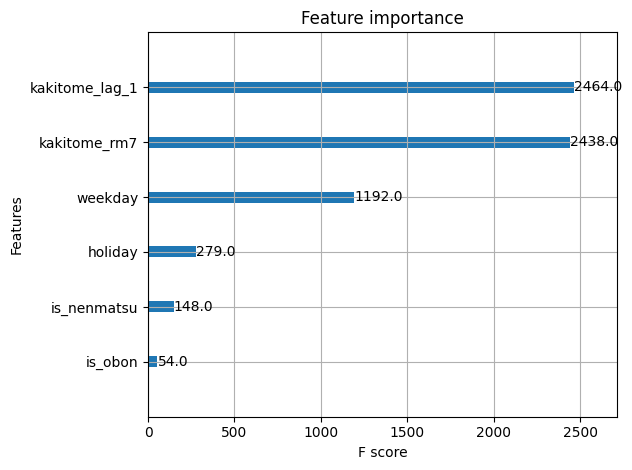

BEST MAE(valid): 126.17909973462423


In [40]:
best_mae, best_model = evaluate_features(BEST_FEATURES)

from xgboost import plot_importance
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plot_importance(best_model)
plt.tight_layout()
plt.show()

print("BEST MAE(valid):", best_mae)


In [41]:
# === セルL1: レターパックプラス用データフレームを作成 ===

df_lp = df.copy()  # すでに weekday, holiday, is_* など入っている df からコピー

# レターパックプラスのラグ・移動平均
df_lp["lpplus_lag_1"] = df_lp["レターパックプラス"].shift(1)
df_lp["lpplus_lag_7"] = df_lp["レターパックプラス"].shift(7)
df_lp["lpplus_rm7"]   = df_lp["レターパックプラス"].rolling(window=7).mean()

# レターパックプラスをターゲットに
df_lp["target"] = df_lp["レターパックプラス"]

# このモデルで使うカラム（レターパックプラスの特徴量）の欠損だけを落とす
df_lp = df_lp.dropna(subset=["target", "lpplus_lag_1", "lpplus_lag_7", "lpplus_rm7"]).reset_index(drop=True)

df_lp[["日付", "レターパックプラス", "lpplus_lag_1", "lpplus_rm7"]].head()


,日付,レターパックプラス,lpplus_lag_1,lpplus_rm7
0,2021-10-15,231.0,254.0,175.714286
1,2021-10-16,159.0,231.0,177.285714
2,2021-10-17,64.0,159.0,177.857143
3,2021-10-18,157.0,64.0,178.714286
4,2021-10-19,189.0,157.0,178.857143


In [42]:
# === セルL2: レターパックプラス用 train / valid 分割 ===

n = len(df_lp)
split_idx = int(n * 0.8)  # 前80%を学習、後20%を検証

train = df_lp.iloc[:split_idx].copy()
valid = df_lp.iloc[split_idx:].copy()

print("train:", train["日付"].min(), "〜", train["日付"].max(), ", len =", len(train))
print("valid:", valid["日付"].min(), "〜", valid["日付"].max(), ", len =", len(valid))

print("train columns:", train.columns.tolist())


train: 2021-10-15 00:00:00 〜 2024-05-22 00:00:00 , len = 951
valid: 2024-05-23 00:00:00 〜 2025-01-15 00:00:00 , len = 238
train columns: ['日付', '通常郵便', '書留', 'ゆうパケット', 'レターパックライト', 'レターパックプラス', '特定記録', 'ゆうパック', 'eパケット', 'EMS', '年賀組立', '年賀配達', 'weekday', 'holiday', 'lag_1', 'lag_7', 'rolling_mean_7', 'month', 'season', 'kakitome_lag_1', 'kakitome_lag_7', 'kakitome_rm7', 'is_gw', 'is_obon', 'is_nenmatsu', 'target', 'lpplus_lag_1', 'lpplus_lag_7', 'lpplus_rm7']


In [43]:
# === セルL3: レターパックプラス ベースライン ===

BASE_FEATURES = ["weekday", "holiday"]

baseline_mae_lp, baseline_model_lp = evaluate_features(BASE_FEATURES)

print("===== BASELINE (レターパックプラス) =====")
print("features:", BASE_FEATURES)
print("MAE(valid):", baseline_mae_lp)


features: ['weekday', 'holiday']
MAE(valid): 27.56164489874319
===== BASELINE (レターパックプラス) =====
features: ['weekday', 'holiday']
MAE(valid): 27.56164489874319


In [44]:
# === セルL4: 特徴量を1つずつ追加して比較（レターパックプラス） ===

CANDIDATE_FEATURES_LP = [
    "lpplus_lag_1",
    "lpplus_lag_7",
    "lpplus_rm7",
    "season",
    "is_gw",
    "is_obon",
    "is_nenmatsu",
]

results_lp = []

for f in CANDIDATE_FEATURES_LP:
    feats = ["weekday", "holiday"] + [f]
    mae, _ = evaluate_features(feats, verbose=False)
    results_lp.append({"features": feats, "MAE": mae})

import pandas as pd
results_lp_df = pd.DataFrame(results_lp)
display(results_lp_df.sort_values("MAE"))


,features,MAE
2,"[weekday, holiday, lpplus_rm7]",23.898690
0,"[weekday, holiday, lpplus_lag_1]",23.927728
6,"[weekday, holiday, is_nenmatsu]",25.140712
3,"[weekday, holiday, season]",27.150565
5,"[weekday, holiday, is_obon]",27.378600
4,"[weekday, holiday, is_gw]",27.798189
1,"[weekday, holiday, lpplus_lag_7]",28.224317


In [46]:
# === セルL5: レターパックプラス用 組み合わせ実験 ===

COMBINATION_LIST_LP = [
    ["weekday", "holiday", "lpplus_lag_1", "lpplus_rm7"],
    ["weekday", "holiday", "lpplus_lag_1", "lpplus_rm7", "is_nenmatsu"],
    ["weekday", "holiday", "lpplus_lag_1", "lpplus_rm7", "is_obon"],
    ["weekday", "holiday", "lpplus_lag_1", "lpplus_rm7", "is_gw"],
    ["weekday", "holiday", "lpplus_lag_1", "lpplus_rm7", "is_obon", "is_nenmatsu"],
    ["weekday", "holiday", "lpplus_lag_1", "lpplus_rm7", "is_gw", "is_obon", "is_nenmatsu"],
]

combo_lp_results = []

for feats in COMBINATION_LIST_LP:
    mae, _ = evaluate_features(feats, verbose=False)
    combo_lp_results.append({"features": feats, "MAE": mae})

combo_lp_df = pd.DataFrame(combo_lp_results)
display(combo_lp_df.sort_values("MAE"))


,features,MAE
2,"[weekday, holiday, lpplus_lag_1, lpplus_rm7, i...",20.856753
4,"[weekday, holiday, lpplus_lag_1, lpplus_rm7, i...",21.098337
3,"[weekday, holiday, lpplus_lag_1, lpplus_rm7, i...",21.136543
5,"[weekday, holiday, lpplus_lag_1, lpplus_rm7, i...",21.143109
1,"[weekday, holiday, lpplus_lag_1, lpplus_rm7, i...",21.246913
0,"[weekday, holiday, lpplus_lag_1, lpplus_rm7]",21.307866


In [47]:
BEST_FEATURES_LP = [
    "weekday",
    "holiday",
    "lpplus_lag_1",
    "lpplus_rm7",
    "is_obon",
    "is_nenmatsu",
]


features: ['weekday', 'holiday', 'lpplus_lag_1', 'lpplus_rm7', 'is_obon', 'is_nenmatsu']
MAE(valid): 21.09833745395436
BEST MAE(valid): 21.09833745395436


<Figure size 600x400 with 0 Axes>

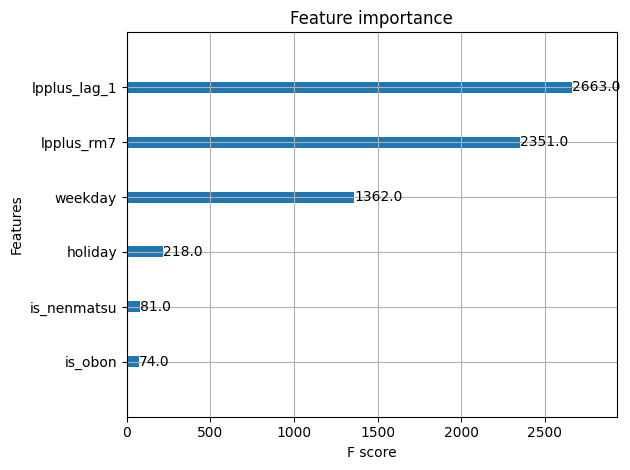

In [48]:
best_mae_lp, best_model_lp = evaluate_features(BEST_FEATURES_LP)

print("BEST MAE(valid):", best_mae_lp)

from xgboost import plot_importance
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plot_importance(best_model_lp)
plt.tight_layout()
plt.show()


In [49]:
# === 書留＋レタパ合計モデル A案 ===

df_sum = df.copy()

# 合計ターゲット
df_sum["target"] = df_sum["書留"] + df_sum["レターパックプラス"]

# lag と rm7 は「合計値」で作る
df_sum["sum_lag_1"] = df_sum["target"].shift(1)
df_sum["sum_lag_7"] = df_sum["target"].shift(7)
df_sum["sum_rm7"]   = df_sum["target"].rolling(window=7).mean()

df_sum = df_sum.dropna().reset_index(drop=True)


In [50]:
FEATURES_SUM = [
    "weekday",
    "holiday",
    "sum_lag_1",
    "sum_rm7",
    "is_obon",
    "is_nenmatsu"
]


In [51]:
train = df_sum.iloc[:split_idx]
valid = df_sum.iloc[split_idx:]

mae_sum, model_sum = evaluate_features(FEATURES_SUM)
print("A案 MAE(valid):", mae_sum)


features: ['weekday', 'holiday', 'sum_lag_1', 'sum_rm7', 'is_obon', 'is_nenmatsu']
MAE(valid): 131.0323529924665
A案 MAE(valid): 131.0323529924665


In [53]:
BEST_FEATURES_KAKITOME = [
    "weekday",
    "holiday",
    "kakitome_lag_1",
    "kakitome_rm7",
    "is_obon",
    "is_nenmatsu",
]

best_mae_kakitome, best_model_kakitome = evaluate_features(BEST_FEATURES_KAKITOME)

print("書留 BEST MAE:", best_mae_kakitome)


features: ['weekday', 'holiday', 'kakitome_lag_1', 'kakitome_rm7', 'is_obon', 'is_nenmatsu']
MAE(valid): 133.0842253741096
書留 BEST MAE: 133.0842253741096


In [58]:
# === レターパックプラス用: df_lp を作り直す ===
df_lp = df.copy()  # 元の df（weekday, holiday, is_* などが入っている前提）

# レターパックプラスのラグ・移動平均を作成
df_lp["lpplus_lag_1"] = df_lp["レターパックプラス"].shift(1)
df_lp["lpplus_lag_7"] = df_lp["レターパックプラス"].shift(7)
df_lp["lpplus_rm7"]   = df_lp["レターパックプラス"].rolling(window=7).mean()

# ターゲットをレターパックプラスに
df_lp["target"] = df_lp["レターパックプラス"]

# 必要なカラムがすべて埋まっている行だけ使う
df_lp = df_lp.dropna(subset=[
    "target",
    "weekday", "holiday",
    "lpplus_lag_1", "lpplus_rm7",
    "is_obon", "is_nenmatsu",
]).reset_index(drop=True)

print(df_lp.columns)
print(len(df_lp))


Index(['日付', '通常郵便', '書留', 'ゆうパケット', 'レターパックライト', 'レターパックプラス', '特定記録', 'ゆうパック',
       'eパケット', 'EMS', '年賀組立', '年賀配達', 'weekday', 'holiday', 'lag_1', 'lag_7',
       'rolling_mean_7', 'month', 'season', 'kakitome_lag_1', 'kakitome_lag_7',
       'kakitome_rm7', 'is_gw', 'is_obon', 'is_nenmatsu', 'target',
       'lpplus_lag_1', 'lpplus_lag_7', 'lpplus_rm7'],
      dtype='object')
1190


In [59]:
# === レターパックプラス用の train / valid を再作成 ===
n = len(df_lp)
split_idx = int(n * 0.8)

train = df_lp.iloc[:split_idx].copy()
valid = df_lp.iloc[split_idx:].copy()

print("train cols:", train.columns.tolist())
print("valid cols:", valid.columns.tolist())


train cols: ['日付', '通常郵便', '書留', 'ゆうパケット', 'レターパックライト', 'レターパックプラス', '特定記録', 'ゆうパック', 'eパケット', 'EMS', '年賀組立', '年賀配達', 'weekday', 'holiday', 'lag_1', 'lag_7', 'rolling_mean_7', 'month', 'season', 'kakitome_lag_1', 'kakitome_lag_7', 'kakitome_rm7', 'is_gw', 'is_obon', 'is_nenmatsu', 'target', 'lpplus_lag_1', 'lpplus_lag_7', 'lpplus_rm7']
valid cols: ['日付', '通常郵便', '書留', 'ゆうパケット', 'レターパックライト', 'レターパックプラス', '特定記録', 'ゆうパック', 'eパケット', 'EMS', '年賀組立', '年賀配達', 'weekday', 'holiday', 'lag_1', 'lag_7', 'rolling_mean_7', 'month', 'season', 'kakitome_lag_1', 'kakitome_lag_7', 'kakitome_rm7', 'is_gw', 'is_obon', 'is_nenmatsu', 'target', 'lpplus_lag_1', 'lpplus_lag_7', 'lpplus_rm7']


In [60]:
pred_kakitome = best_model_kakitome.predict(valid[BEST_FEATURES_KAKITOME])
pred_lpplus   = best_model_lp.predict(valid[BEST_FEATURES_LP])

pred_sum = pred_kakitome + pred_lpplus
true_sum = valid["書留"] + valid["レターパックプラス"]

from sklearn.metrics import mean_absolute_error
mae_after = mean_absolute_error(true_sum, pred_sum)

print("B案（予測後に足す方式） MAE(valid):", mae_after)


B案（予測後に足す方式） MAE(valid): 205.3435179125361


In [61]:
# === 合計モデル用 df_sum を作る ===

df_sum = df.copy()  # すでに weekday, holiday, is_* が入っている前提

# 合計ターゲット
df_sum["sum_target"] = df_sum["書留"] + df_sum["レターパックプラス"]

# lag / rolling
df_sum["sum_lag_1"] = df_sum["sum_target"].shift(1)
df_sum["sum_lag_7"] = df_sum["sum_target"].shift(7)
df_sum["sum_rm7"]   = df_sum["sum_target"].rolling(window=7).mean()

# 学習に必要なカラムが揃っている行だけに絞る
df_sum = df_sum.dropna(subset=[
    "sum_target",
    "weekday", "holiday",
    "sum_lag_1", "sum_rm7",
    "is_obon", "is_nenmatsu",
]).reset_index(drop=True)

df_sum[["日付", "sum_target", "sum_lag_1", "sum_rm7"]].head()


,日付,sum_target,sum_lag_1,sum_rm7
0,2021-10-14,2149.0,1352.0,1411.142857
1,2021-10-15,1764.0,2149.0,1402.285714
2,2021-10-16,1706.0,1764.0,1360.714286
3,2021-10-17,1182.0,1706.0,1380.000000
4,2021-10-18,762.0,1182.0,1406.142857


In [62]:
# === 合計モデル用 train / valid ===

n = len(df_sum)
split_idx = int(n * 0.8)

train_sum = df_sum.iloc[:split_idx].copy()
valid_sum = df_sum.iloc[split_idx:].copy()

print("train_sum:", train_sum["日付"].min(), "〜", train_sum["日付"].max(), ", len =", len(train_sum))
print("valid_sum:", valid_sum["日付"].min(), "〜", valid_sum["日付"].max(), ", len =", len(valid_sum))


train_sum: 2021-10-14 00:00:00 〜 2024-05-22 00:00:00 , len = 952
valid_sum: 2024-05-23 00:00:00 〜 2025-01-15 00:00:00 , len = 238


In [63]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

def evaluate_sum_features(feature_list, model_params=None, verbose=True):
    if model_params is None:
        model_params = dict(
            n_estimators=300,
            max_depth=5,
            learning_rate=0.05,
            subsample=0.9,
            colsample_bytree=0.9,
            random_state=42,
            n_jobs=-1,
        )
    
    X_train = train_sum[feature_list]
    y_train = train_sum["sum_target"]
    X_valid = valid_sum[feature_list]
    y_valid = valid_sum["sum_target"]
    
    model = XGBRegressor(**model_params)
    model.fit(X_train, y_train)
    
    pred_valid = model.predict(X_valid)
    mae = mean_absolute_error(y_valid, pred_valid)
    
    if verbose:
        print("features:", feature_list)
        print("MAE(valid):", mae)
    
    return mae, model


In [64]:
BASE_FEATURES_SUM = ["weekday", "holiday"]
mae_base_sum, _ = evaluate_sum_features(BASE_FEATURES_SUM)
print("BASE MAE (合計):", mae_base_sum)


features: ['weekday', 'holiday']
MAE(valid): 192.18007320115547
BASE MAE (合計): 192.18007320115547


In [65]:
import pandas as pd

CANDIDATE_COMBOS = [
    ["weekday", "holiday", "sum_lag_1"],
    ["weekday", "holiday", "sum_lag_1", "sum_rm7"],
    ["weekday", "holiday", "sum_lag_1", "sum_rm7", "is_obon"],
    ["weekday", "holiday", "sum_lag_1", "sum_rm7", "is_nenmatsu"],
    ["weekday", "holiday", "sum_lag_1", "sum_rm7", "is_obon", "is_nenmatsu"],
    ["weekday", "holiday", "sum_lag_1", "sum_rm7", "sum_lag_7", "is_obon", "is_nenmatsu"],
    ["weekday", "holiday", "sum_lag_1", "sum_rm7", "season", "is_obon", "is_nenmatsu"],
    ["weekday", "holiday", "sum_lag_1", "sum_rm7", "season", "is_gw", "is_obon", "is_nenmatsu"],
]

sum_results = []

for feats in CANDIDATE_COMBOS:
    # 存在しないカラムが入ってるとエラーになるのでチェック
    feats_ok = [c for c in feats if c in train_sum.columns]
    mae, _ = evaluate_sum_features(feats_ok, verbose=False)
    sum_results.append({"features": feats_ok, "MAE": mae})

sum_results_df = pd.DataFrame(sum_results)
display(sum_results_df.sort_values("MAE"))


,features,MAE
5,"[weekday, holiday, sum_lag_1, sum_rm7, sum_lag...",128.745157
4,"[weekday, holiday, sum_lag_1, sum_rm7, is_obon...",130.887841
6,"[weekday, holiday, sum_lag_1, sum_rm7, season,...",132.596714
2,"[weekday, holiday, sum_lag_1, sum_rm7, is_obon]",133.239893
3,"[weekday, holiday, sum_lag_1, sum_rm7, is_nenm...",133.400653
7,"[weekday, holiday, sum_lag_1, sum_rm7, season,...",135.281575
1,"[weekday, holiday, sum_lag_1, sum_rm7]",135.902308
0,"[weekday, holiday, sum_lag_1]",148.185829


In [66]:
BEST_FEATURES_SUM = [
    "weekday",
    "holiday",
    "sum_lag_1",
    "sum_rm7",
    "sum_lag_7",
    "is_obon",
    "is_nenmatsu",
]

In [67]:
param_grid = [
    dict(n_estimators=200, max_depth=3, learning_rate=0.05),
    dict(n_estimators=300, max_depth=3, learning_rate=0.05),
    dict(n_estimators=400, max_depth=4, learning_rate=0.05),
    dict(n_estimators=300, max_depth=4, learning_rate=0.03),
    dict(n_estimators=500, max_depth=5, learning_rate=0.03),
    dict(n_estimators=300, max_depth=6, learning_rate=0.02),
]

hp_results = []

for params in param_grid:
    p = params.copy()
    p.update(dict(subsample=0.9, colsample_bytree=0.9, random_state=42, n_jobs=-1))
    mae, _ = evaluate_sum_features(BEST_FEATURES_SUM, model_params=p, verbose=False)
    hp_results.append({"params": p, "MAE": mae})

import pandas as pd
hp_results_df = pd.DataFrame(hp_results)
display(hp_results_df.sort_values("MAE"))


,params,MAE
1,"{'n_estimators': 300, 'max_depth': 3, 'learnin...",121.278058
0,"{'n_estimators': 200, 'max_depth': 3, 'learnin...",122.221549
3,"{'n_estimators': 300, 'max_depth': 4, 'learnin...",123.153375
2,"{'n_estimators': 400, 'max_depth': 4, 'learnin...",126.982889
5,"{'n_estimators': 300, 'max_depth': 6, 'learnin...",128.318583
4,"{'n_estimators': 500, 'max_depth': 5, 'learnin...",128.764786


In [68]:
BEST_FEATURES_SUM = [
    "weekday",
    "holiday",
    "sum_lag_1",
    "sum_rm7",
    "sum_lag_7",
    "is_obon",
    "is_nenmatsu",
]

BEST_PARAMS_SUM = dict(
    n_estimators=300,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    n_jobs=-1,
)

In [69]:
best_mae_sum, best_model_sum = evaluate_sum_features(
    BEST_FEATURES_SUM,
    model_params=BEST_PARAMS_SUM,
)

print("合計モデル BEST MAE(valid):", best_mae_sum)


features: ['weekday', 'holiday', 'sum_lag_1', 'sum_rm7', 'sum_lag_7', 'is_obon', 'is_nenmatsu']
MAE(valid): 121.2780583165273
合計モデル BEST MAE(valid): 121.2780583165273


<Figure size 600x400 with 0 Axes>

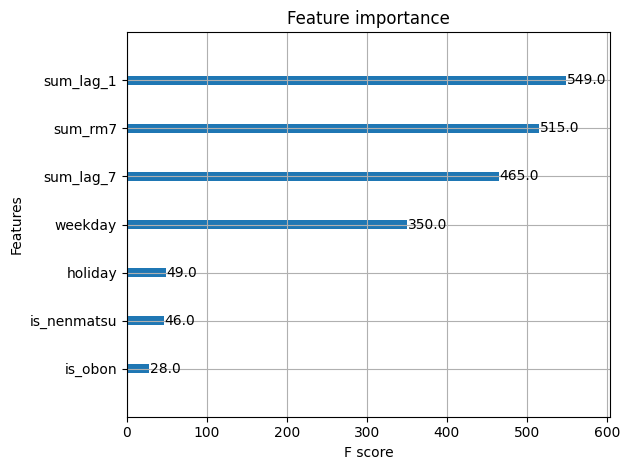

In [70]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plot_importance(best_model_sum)
plt.tight_layout()
plt.show()

In [71]:
# === 未来365日のカレンダー作成 ===

last_date = df_sum["日付"].max()
future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=365, freq="D")

future = pd.DataFrame({"日付": future_dates})


In [72]:
# weekday, holiday
future["weekday"] = future["日付"].dt.weekday
future["holiday"] = future["日付"].apply(lambda d: 1 if jpholiday.is_holiday(d) or d.weekday() >= 5 else 0)

# season
future["month"] = future["日付"].dt.month
future["season"] = future["month"] % 12 // 3

# Event flags
future["is_gw"] = future["日付"].apply(lambda d: 1 if is_gw(d) else 0)
future["is_obon"] = future["日付"].apply(lambda d: 1 if is_obon(d) else 0)
future["is_nenmatsu"] = future["日付"].apply(lambda d: 1 if is_nenmatsu(d) else 0)


In [75]:
# === A案: 合計モデルで1年先を予測（修正版） ===

pred_sum_A = []

# 過去データ（合計）の履歴
hist = df_sum[["日付", "sum_target"]].copy().set_index("日付")

for d, row in future.iterrows():
    date = row["日付"]

    # ---- lag 系を履歴から計算 ----
    past = hist.loc[hist.index < date, "sum_target"]

    lag_1 = past.iloc[-1]
    if len(past) >= 7:
        lag_7 = past.iloc[-7]
        rm7   = past.iloc[-7:].mean()
    else:
        lag_7 = lag_1
        rm7   = past.mean()

    # ---- この日付の特徴量1行を組み立てる ----
    # future には weekday, holiday, is_obon, is_nenmatsu が入っている前提
    x = pd.DataFrame({
        "weekday":     [row["weekday"]],
        "holiday":     [row["holiday"]],
        "is_obon":     [row["is_obon"]],
        "is_nenmatsu": [row["is_nenmatsu"]],
        "sum_lag_1":   [lag_1],
        "sum_lag_7":   [lag_7],
        "sum_rm7":     [rm7],
    })

    # BEST_FEATURES_SUM の順番で並べて予測
    x = x[BEST_FEATURES_SUM]

    y_pred = best_model_sum.predict(x)[0]
    pred_sum_A.append(y_pred)

    # 予測結果を履歴に追加（recursive forecasting）
    hist.loc[date] = y_pred

future["A案_pred_sum"] = pred_sum_A


In [77]:
# === B案: 書留＋レターパックプラスを別々に予測して合算（修正版） ===

pred_sum_B = []

# 履歴（過去実績）
hist_k = df[["日付", "書留"]].set_index("日付").copy()
hist_lp = df[["日付", "レターパックプラス"]].set_index("日付").copy()

for _, row in future.iterrows():
    date = row["日付"]

    # --------------------
    # 1) 書留の予測
    # --------------------
    past_k = hist_k.loc[hist_k.index < date, "書留"]
    k_lag1 = past_k.iloc[-1]
    if len(past_k) >= 7:
        k_rm7 = past_k.iloc[-7:].mean()
    else:
        k_rm7 = past_k.mean()

    x_k = pd.DataFrame({
        "weekday":        [row["weekday"]],
        "holiday":        [row["holiday"]],
        "is_obon":        [row["is_obon"]],
        "is_nenmatsu":    [row["is_nenmatsu"]],
        "kakitome_lag_1": [k_lag1],
        "kakitome_rm7":   [k_rm7],
    })

    x_k = x_k[BEST_FEATURES_KAKITOME]

    y_k = best_model_kakitome.predict(x_k)[0]

    # --------------------
    # 2) レターパックプラスの予測
    # --------------------
    past_lp = hist_lp.loc[hist_lp.index < date, "レターパックプラス"]
    lp_lag1 = past_lp.iloc[-1]
    if len(past_lp) >= 7:
        lp_rm7 = past_lp.iloc[-7:].mean()
    else:
        lp_rm7 = past_lp.mean()

    x_lp = pd.DataFrame({
        "weekday":      [row["weekday"]],
        "holiday":      [row["holiday"]],
        "is_obon":      [row["is_obon"]],
        "is_nenmatsu":  [row["is_nenmatsu"]],
        "lpplus_lag_1": [lp_lag1],
        "lpplus_rm7":   [lp_rm7],
    })

    x_lp = x_lp[BEST_FEATURES_LP]

    y_lp = best_model_lp.predict(x_lp)[0]

    # --------------------
    # 3) 合計
    # --------------------
    pred_sum_B.append(y_k + y_lp)

    # 履歴に予測を追加（recursive）
    hist_k.loc[date] = y_k
    hist_lp.loc[date] = y_lp

future["B案_pred_sum"] = pred_sum_B


/Users/hiraokatatsuru/miniconda3/envs/posms311/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/hiraokatatsuru/miniconda3/envs/posms311/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20808 (\N{CJK UNIFIED IDEOGRAPH-5148}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/hiraokatatsuru/miniconda3/envs/posms311/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20104 (\N{CJK UNIFIED IDEOGRAPH-4E88}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/hiraokatatsuru/miniconda3/envs/posms311/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 28204 (\N{CJK UNIFIED IDEOGRAPH-6E2C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/hiraokatatsuru/miniconda3

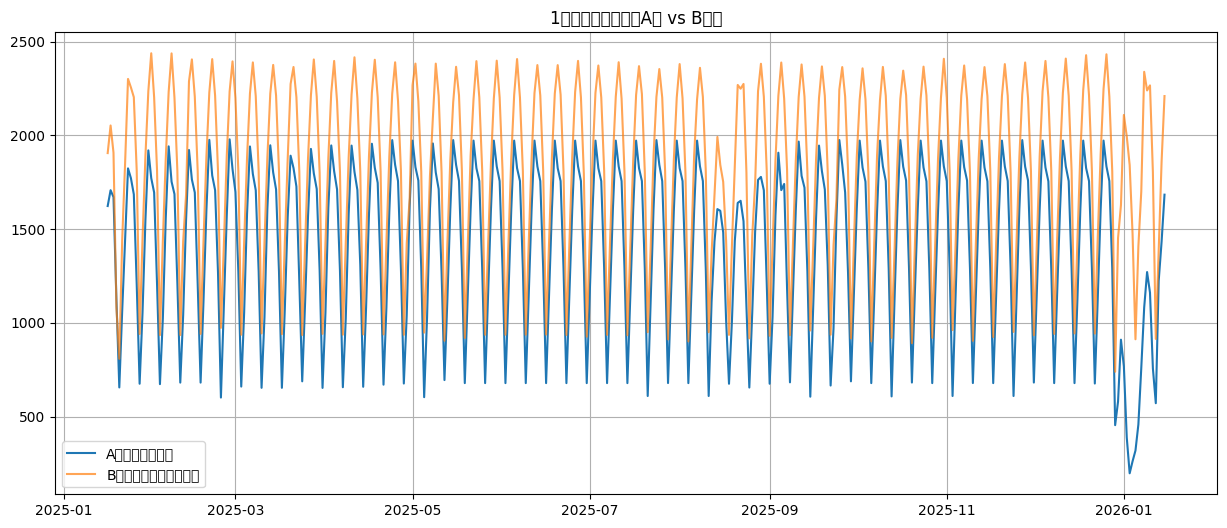

In [78]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(future["日付"], future["A案_pred_sum"], label="A案：合計モデル")
plt.plot(future["日付"], future["B案_pred_sum"], label="B案：書留＋レタパ合算", alpha=0.7)
plt.legend()
plt.title("1年先予測の比較（A案 vs B案）")
plt.grid()
plt.show()


In [79]:
# 合計ターゲット
df_sum = df.copy()
df_sum["sum_target"] = df_sum["書留"] + df_sum["レターパックプラス"]
df_sum["sum_lag_1"] = df_sum["sum_target"].shift(1)
df_sum["sum_lag_7"] = df_sum["sum_target"].shift(7)
df_sum["sum_rm7"]   = df_sum["sum_target"].rolling(7).mean()

df_sum = df_sum.dropna().reset_index(drop=True)

# 特徴量（さっき決めた最強セット）
BEST_FEATURES_SUM = [
    "weekday",
    "holiday",
    "sum_lag_1",
    "sum_rm7",
    "sum_lag_7",
    "is_obon",
    "is_nenmatsu",
]

# train / valid 分割（時系列）
n = len(df_sum)
split_idx = int(n * 0.8)
train_sum = df_sum.iloc[:split_idx].copy()
valid_sum = df_sum.iloc[split_idx:].copy()

X_train_sum = train_sum[BEST_FEATURES_SUM]
y_train_sum = train_sum["sum_target"]
X_valid_sum = valid_sum[BEST_FEATURES_SUM]
y_valid_sum = valid_sum["sum_target"]


In [80]:
import optuna
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

def objective_sum(trial: optuna.Trial) -> float:
    # 探索するハイパーパラメータの範囲
    max_depth = trial.suggest_int("max_depth", 2, 6)
    n_estimators = trial.suggest_int("n_estimators", 200, 700, step=50)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.2, log=True)
    subsample = trial.suggest_float("subsample", 0.7, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.7, 1.0)

    params = dict(
        max_depth=max_depth,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=42,
        n_jobs=-1,
    )

    model = XGBRegressor(**params)
    model.fit(X_train_sum, y_train_sum)

    pred_valid = model.predict(X_valid_sum)
    mae = mean_absolute_error(y_valid_sum, pred_valid)

    return mae


In [81]:
study = optuna.create_study(direction="minimize")
study.optimize(objective_sum, n_trials=30)  # トライ数はあとで増やしてもOK

print("Best trial:", study.best_trial.number)
print("Best MAE:", study.best_value)
print("Best params:", study.best_params)


[I 2025-12-07 14:51:07,272] A new study created in memory with name: no-name-ab4b2786-6bcc-478c-a659-4be6dcba0723
[I 2025-12-07 14:51:07,455] Trial 0 finished with value: 125.11005985035615 and parameters: {'max_depth': 2, 'n_estimators': 600, 'learning_rate': 0.026339212211617162, 'subsample': 0.8486322396329157, 'colsample_bytree': 0.8278936713968083}. Best is trial 0 with value: 125.11005985035615.
[I 2025-12-07 14:51:07,554] Trial 1 finished with value: 129.944947378976 and parameters: {'max_depth': 2, 'n_estimators': 400, 'learning_rate': 0.024793840304610758, 'subsample': 0.9084145107685648, 'colsample_bytree': 0.8299443420746659}. Best is trial 0 with value: 125.11005985035615.
[I 2025-12-07 14:51:07,763] Trial 2 finished with value: 144.4049833922827 and parameters: {'max_depth': 6, 'n_estimators': 350, 'learning_rate': 0.09967547634691772, 'subsample': 0.8861513619873633, 'colsample_bytree': 0.8275759219760677}. Best is trial 0 with value: 125.11005985035615.
[I 2025-12-07 14:

Best trial: 13
Best MAE: 122.01794657987706
Best params: {'max_depth': 3, 'n_estimators': 450, 'learning_rate': 0.042083206601567356, 'subsample': 0.7846159365901959, 'colsample_bytree': 0.9844740049356739}


In [82]:
BEST_PARAMS_SUM = study.best_params.copy()
BEST_PARAMS_SUM.update(dict(random_state=42, n_jobs=-1))

print(BEST_PARAMS_SUM)


{'max_depth': 3, 'n_estimators': 450, 'learning_rate': 0.042083206601567356, 'subsample': 0.7846159365901959, 'colsample_bytree': 0.9844740049356739, 'random_state': 42, 'n_jobs': -1}


In [83]:
best_mae_sum_opt, best_model_sum_opt = evaluate_sum_features(
    BEST_FEATURES_SUM,
    model_params=BEST_PARAMS_SUM,
    verbose=True,
)

print("Optuna後 合計モデル MAE(valid):", best_mae_sum_opt)


features: ['weekday', 'holiday', 'sum_lag_1', 'sum_rm7', 'sum_lag_7', 'is_obon', 'is_nenmatsu']
MAE(valid): 122.01794657987706
Optuna後 合計モデル MAE(valid): 122.01794657987706


In [7]:
from posms.models.registered_plus import (
    TARGET,
    FEATURES_REGISTERED_PLUS,
    train_from_hist,
    forecast_from_sum,
)
print(TARGET, FEATURES_REGISTERED_PLUS)


registered_plus ['weekday', 'holiday', 'is_obon', 'is_nenmatsu', 'sum_lag_1', 'sum_rm7', 'sum_lag_7']


In [8]:
from posms.models.registered_plus import TARGET, FEATURES_REGISTERED_PLUS
print(TARGET)
print(FEATURES_REGISTERED_PLUS)


registered_plus
['weekday', 'holiday', 'is_obon', 'is_nenmatsu', 'sum_lag_1', 'sum_rm7', 'sum_lag_7']


In [12]:
import pandas as pd

# 例：過去実績CSV（パスはあなたの環境に合わせて変更）
path = "/Users/hiraokatatsuru/Library/Mobile Documents/com~apple~CloudDocs/postal-operation-shift-management-system/db/init/csv/postal_datas.csv"

hist_df = pd.read_csv(path)

# 日付列がある場合（例: "日付"）→ index にする
hist_df["日付"] = pd.to_datetime(hist_df["日付"])
hist_df = hist_df.set_index("日付").sort_index()

hist_df.head()


,通常郵便,書留,ゆうパケット,レターパックライト,レターパックプラス,特定記録,ゆうパック,eパケット,EMS,年賀組立,年賀配達
日付,,,,,,,,,,,
2021-10-01,63000.0,1783.0,882.0,615.0,264.0,588.0,1126.0,200.0,150.0,0.0,0.0
2021-10-02,0.0,1951.0,673.0,337.0,144.0,0.0,1534.0,0.0,158.0,0.0,0.0
2021-10-03,0.0,1054.0,898.0,151.0,65.0,0.0,1177.0,0.0,142.0,0.0,0.0
2021-10-04,102000.0,540.0,688.0,369.0,158.0,557.0,1595.0,400.0,274.0,0.0,0.0
2021-10-05,45000.0,721.0,877.0,443.0,190.0,451.0,1083.0,150.0,179.0,0.0,0.0


In [13]:
required = ["書留", "レターパックプラス", "sum"]
print("missing:", [c for c in required if c not in hist_df.columns])


missing: ['sum']


In [14]:
import numpy as np
import pandas as pd

idx = pd.date_range("2025-01-01", periods=200, freq="D")
hist_df = pd.DataFrame(index=idx)

# 仮の総物数
hist_df["sum"] = 5000 + 200*np.sin(np.arange(len(idx))*2*np.pi/7) + np.random.normal(0, 150, len(idx))

# 仮の書留・LP+
hist_df["書留"] = 120 + 0.01*hist_df["sum"] + np.random.normal(0, 10, len(idx))
hist_df["レターパックプラス"] = 80 + 0.008*hist_df["sum"] + np.random.normal(0, 8, len(idx))

# フラグ類（なければ0でもOK）
hist_df["holiday"] = 0
hist_df["is_obon"] = 0
hist_df["is_nenmatsu"] = 0

hist_df.head()


,sum,書留,レターパックプラス,holiday,is_obon,is_nenmatsu
2025-01-01,4945.388209,163.392805,131.192012,0,0,0
2025-01-02,4931.958638,160.889280,108.655933,0,0,0
2025-01-03,5272.131424,174.326658,134.282296,0,0,0
2025-01-04,5177.597079,173.250421,117.635397,0,0,0
2025-01-05,4962.486852,154.876513,108.392904,0,0,0


In [15]:
res = train_from_hist(
    df_hist=hist_df,
    valid_days=30,
    experiment_name="posms",
    run_name="posms-registered_plus-test",
)

print(res.run_id)
print(res.metrics)


2025/12/14 10:16:26 INFO mlflow.tracking.fluent: Experiment with name 'posms' does not exist. Creating a new experiment.
/Users/hiraokatatsuru/miniconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:16:26] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/12/14 10:16:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


dfaff3ef770d4ccb932875fe9dc68c76
{'mae': 10.678607164200931, 'rmse': 12.834209666214484}


In [16]:
import pandas as pd

def check_hist_df(hist_df: pd.DataFrame):
    assert isinstance(hist_df.index, pd.DatetimeIndex), "hist_df.index が DatetimeIndex ではありません"
    required = ["書留", "レターパックプラス", "sum"]
    missing = [c for c in required if c not in hist_df.columns]
    assert not missing, f"hist_df に必須列がありません: {missing}"

    # 任意列が無いなら 0 で補完（モデル側でも補完していますがここでも確認）
    for c in ["holiday", "is_obon", "is_nenmatsu"]:
        if c not in hist_df.columns:
            hist_df[c] = 0

    # ソート・重複確認
    assert hist_df.index.is_monotonic_increasing, "hist_df が日付順にソートされていません"
    assert not hist_df.index.duplicated().any(), "hist_df に同一日付が重複しています"

    print("✅ hist_df check OK")
    print("rows:", len(hist_df), "from:", hist_df.index.min(), "to:", hist_df.index.max())

check_hist_df(hist_df)


✅ hist_df check OK
rows: 200 from: 2025-01-01 00:00:00 to: 2025-07-19 00:00:00


In [17]:
res = train_from_hist(
    df_hist=hist_df,
    valid_days=30,
    experiment_name="posms",
    run_name="posms-registered_plus",
)

print("✅ train OK")
print("run_id:", res.run_id)
print("metrics:", res.metrics)


/Users/hiraokatatsuru/miniconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:17:22] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/12/14 10:17:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ train OK
run_id: bc21e19743274bfeb1cf899adc366817
metrics: {'mae': 10.678607164200931, 'rmse': 12.834209666214484}


In [18]:
import numpy as np

# 未来日を作る（例：30日先まで）
future_index = pd.date_range(hist_df.index.max() + pd.Timedelta(days=1), periods=30, freq="D")

# ダミー sum_future（過去の直近値をベースに少しノイズ）
base = float(hist_df["sum"].iloc[-1])
sum_future = pd.Series(base + np.random.normal(0, base * 0.05, size=len(future_index)),
                       index=future_index, name="sum")

# 予測開始日（未来の最初の日）
pred_start_date = future_index.min()

forecast_res = forecast_from_sum(
    model_registered_plus=res.model,
    df_hist=hist_df,
    sum_future=sum_future,
    pred_start_date=pred_start_date,
)

print("✅ forecast OK")
display(forecast_res.df_future_feat.head())
display(forecast_res.y_pred.head())


✅ forecast OK


,weekday,holiday,is_obon,is_nenmatsu,sum_lag_1,sum_rm7,sum_lag_7
2025-07-20,6,0,0,0,5113.896189,4922.811623,4793.658747
2025-07-21,0,0,0,0,4805.535893,4924.508358,4459.528291
2025-07-22,1,0,0,0,4780.332773,4970.337570,4761.121664
2025-07-23,2,0,0,0,5395.933530,5061.024980,4887.042026
2025-07-24,3,0,0,0,5260.289764,5114.346085,5244.966442


2025-07-20    291.417938
2025-07-21    305.720245
2025-07-22    291.501465
2025-07-23    288.979980
2025-07-24    289.448303
Freq: D, Name: registered_plus_pred, dtype: float32

In [19]:
print("future_feat rows:", len(forecast_res.df_future_feat))
print("future_feat range:", forecast_res.df_future_feat.index.min(), "->", forecast_res.df_future_feat.index.max())

assert len(forecast_res.df_future_feat) > 0, "未来特徴量が 0 行です（未来期間が短すぎる可能性）"


future_feat rows: 30
future_feat range: 2025-07-20 00:00:00 -> 2025-08-18 00:00:00
